In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns; sns.set()
import numpy as np

In [2]:
# ^GSPTSE is the ticker for the S&P/TSX
# Grab weekly prices as they contain relatively less noise
# We are interested in the Adj Close column as it contains the prices adjusted for dividends
index_prices = yf.download("^GSPTSE", interval="1wk")['Adj Close']

# Get the log returns for the index and drop empty rows
index_returns = np.log(index_prices / index_prices.shift(1)).dropna()

# Regressions do not work well with outliers, we need to remove them
# Here, I remove returns that have less than 1% chance of occuring
index_returns = index_returns[index_returns.between(index_returns.quantile(.005), index_returns.quantile(.995))]
index_returns.head()

[*********************100%***********************]  1 of 1 downloaded


Date
1979-07-02   -0.019845
1979-07-09   -0.031497
1979-07-16    0.012983
1979-07-23    0.013078
1979-07-30   -0.012885
Name: Adj Close, dtype: float64

In [3]:
# a function that takes in weekly returns the window length in years
def rolling_volatility(weekly_returns, window_length):
    weekly_returns = weekly_returns.rolling(52 * window_length).std()
    annual_volatility = weekly_returns * 52 ** 0.5 
    return  annual_volatility

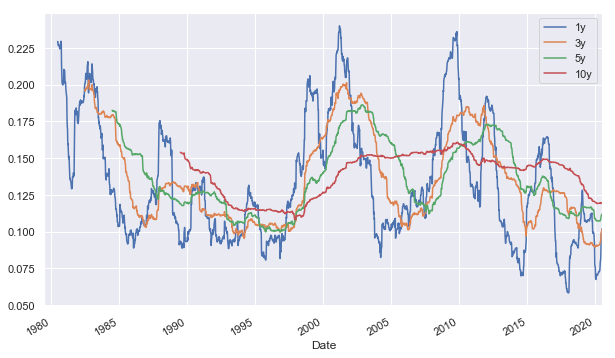

In [4]:
volatility_df = pd.DataFrame()
for time_period in [1, 3, 5, 10]:
    volatility_df[str(time_period) + "y"] = rolling_volatility(index_returns, time_period)
volatility_df.plot(figsize=(10,6))

In [5]:
# A method that tells us what's the future volatility from time T to T+1
realized_annual_vol = volatility_df["1y"].shift(-52)

# let's include this column to our volatility table
volatility_df["Next Year Volatility"] = realized_annual_vol
volatility_df.dropna(inplace=True)

# Let's compute the R2
r_squared = volatility_df.corrwith(realized_annual_vol) ** 2

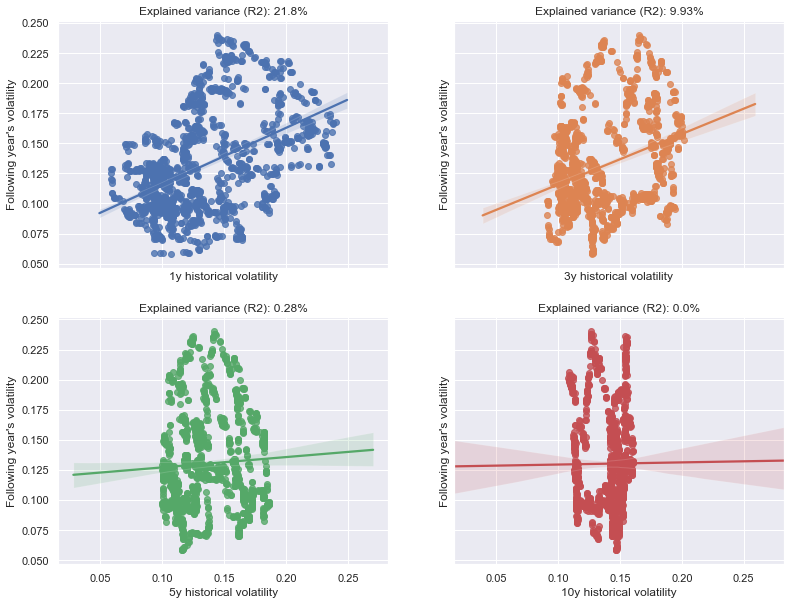

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(13, 10), sharex=True, sharey=True)
i = 0
j = 0
for t in ["1y", "3y", "5y","10y"]:
    sns.regplot(volatility_df[t], volatility_df["Next Year Volatility"], ci=99, ax=axes[j][i])
    axes[j][i].set_title("Explained variance (R2): {}%".format(round(r_squared[t] * 100, 2)))
    axes[j][i].set_xlabel(t + " historical volatility")
    axes[j][i].set_ylabel("Following year's volatility")
    if i == 1:
        j += 1
        i = 0
    else:
        i+=1

In [7]:
# predict future volatility using historical volatility
predicted_vol = pd.DataFrame()
for t in ["1y", "3y", "5y","10y"]:
    reg = LinearRegression().fit(np.array(volatility_df[t]).reshape(-1, 1), volatility_df["Next Year Volatility"])
    predicted_vol[t] = reg.predict(np.array(volatility_df[t]).reshape(-1, 1))
    
pred_error = predicted_vol.subtract(np.array(volatility_df["Next Year Volatility"]), axis=0)
mae = np.abs(pred_error).mean()

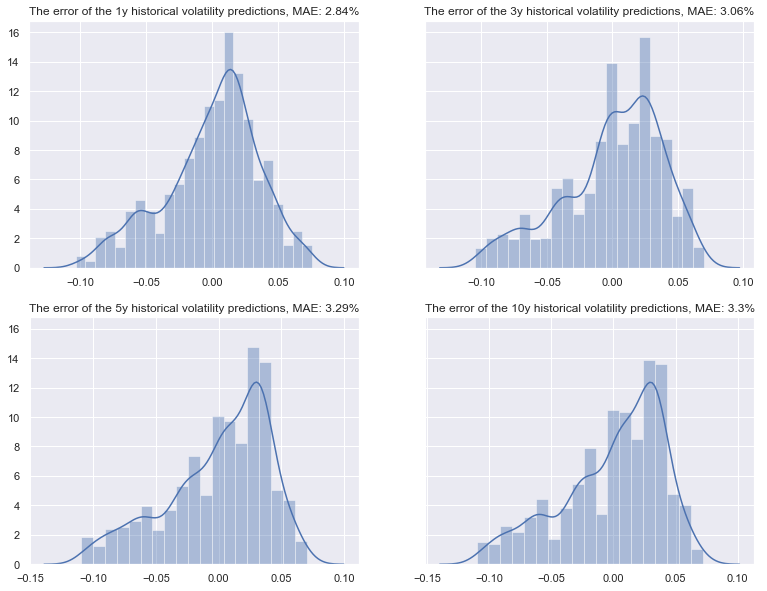

In [8]:
# plot the prediction errors on a histogram
fig, axes = plt.subplots(2, 2, figsize=(13, 10), sharey=True)
i = 0
j = 0
for t in ["1y", "3y", "5y","10y"]:
    sns.distplot(pred_error[t], ax=axes[j][i])
    axes[j][i].set_title("The error of the " + t + " historical volatility predictions, MAE: {}%".format(round(mae[t] *100, 2)))
    axes[j][i].set_xlabel("")
    axes[j][i]
    if i == 1:
        j += 1
        i = 0
    else:
        i+=1
